# Cluster updates

## Critical Slowing down

The Metropolis Monte Carlo method works very well in simulating the properties of the 2D Ising model. However, close to the Curie temperature $T_c$, the simulations suffer from critical slowing down, and more efficient algorithms are needed. Cluster update algorithms are the most succesful global update
methods in use. These methods update the variables globally, in
one step, whereas the standard local methods operate on one variable
at a time. These cluster algorithms are useful in many applications involving graphs and lattices.

A global update can reduce the autocorrelation time of the update
and thus greatly reduce the statistical errors.

The Ising model does not have dynamics built into it: there is no kinetic energy term associated with the spins $s_i$. The Metropolis Monte Carlo method generates successive configurations of spins, but this does not represent the real time evolution of a system of spins.
In a real system, the dynamical variables are functions of time. An interesting quantity is the relaxation time, which is the time scale over which the system approaches equilibrium. If $A(t)$ is a quantity which relaxes towards its equilibrium value $A_0$, the the relaxation time can be theoretically described as

$$
\tau = \frac {\int_0^\infty 􏰈dt t[A(t)−A_0]}{\int_0^\infty 􏰈dt [A(t)−A_0]}.
$$

Near the critical temperature, the relaxation time becomes very large and can be shown to diverge for an infinite system.

### Autocorrelation time in Metropolis simulations
In a Metropolis simulation, the successive spin configurations also exhibit a type of critical slowing down near the phase transition temperature $T_c(L)$ of the finite lattice. This is not the same as relaxation in a real system. However, it is useful to measure a relaxation time for the Metropolis “dynamics” because it helps to determine how many steps to skip in order to generate statistically independent configurations.
Recall that one Monte Carlo step per spin is taken conventionally to be N Metropolis steps. If the correlation time is of the order of a single Monte Carlo step, then every configuration can be used in measuring averages. But if the correlation time is longer, then approximately $\tau$ Monte Carlo steps should be discarded between every data point.
The time autocorrelation function is defined as:

$$
C(t) = \frac {\frac{1}{N-t} \sum_i A_i A_{i+t}}{A_0^2} \sim e^{-t/\tau}
$$

where

$$
A_i = \langle A \rangle _i - A_0
$$
is the measured value of the observable $A$ in iteration $i$.

If Monte Carlo steps separated in time by $t$ intermediate steps
are truly uncorrelated, then $C(t)$ should be zero (i.e., of $O(1/ M)$ where $M$ is the number of steps used in computing the averages).


## Swendsen-Wang cluster update
[Swendsen and Wang, PRL 58 (1987) 86]

Beginning with an arbitary spin $s_i$, one SW cluster update cycle consists of:

1. Inspect all nearest neighbor spins $s_j$. If $s_i = s_j$, create a bond between sites
$i, j$ with probability $p = 1 − \exp(−2\beta)$ (otherwise, no bond).
2. Construct clusters = sets of points connected by bonds.
3. Set each cluster to a random value $\pm 1$.

![sw](figures/sw.png)
#### Figure illustrating how clutsers are build for a global update.

## Wolff single cluster update
[U. Wolff, PRL 62 (1989) 361]

Principle: do the cluster decomposition as in SW, but invert (‘flip’) only
one randomly chosen cluster! In practice:

1. Choose random site $i$.
2. Study neighbouring sites $j$. If $s_j = s_i$, join site $j$ to cluster with
probability $p = 1 − \exp(−2\beta)$.

3. Repeat step 2 for site $j$, if it was joined to the cluster. Keep on doing
this as long as the cluster grows.

4. When the cluster is finished, invert the spins which belong to it.

### Properties
- Usually slightly more effective than SW.
- The minimum cluster size = 1, maximum = volume.
- Nicely recursive.
- Satisfies ergodicity and detailed balance
- Performance is **worse** than single updates away from the transition

In what models clusters work, in what models they fail?
Clusters (usually) fail, if

- there are frustrated couplings (spin glasses, gauge theories . . . )
- one cannot construct a symmetric reflection operation
- spins are ‘frozen’ in place by external fields etc.

Cluster updates are (normally) usable only in proximity of a 2nd order
phase transitions: large correlation lengths mean large clusters.
Nevertheless, sometimes they are useful when correlation lengths are
finite but still large.


In [10]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot
import matplotlib.animation as animation
from JSAnimation.IPython_display import display_animation

class BoundaryCondition:
    RBC, PBC = range(2)
    
class Direction:
    RIGHT, TOP, LEFT, BOTTOM = range(4)
    
class Ising(object):
    
    def __init__ (self, L, J, T):
      
        self.L = L
        self.N = L*L
        self.TWOJ = 2.*J
        self.T = T
        self.beta = 1./T
        self.wcluster = np.exp(-2*self.beta)
        
        # Initialize site positions
        # Initialize neighbors table for boundary conditions
        self.nn = np.zeros(shape=(self.N,4), dtype=np.int16)
        self.position = np.zeros(shape=(L,L), dtype=np.int16)
        self.x = np.zeros(self.N, dtype=np.int16)
        self.y = np.zeros(self.N, dtype=np.int16)

        # Periodic boundary conditions
        n = 0
        for iy in range(L):
            for ix in range(L):
                self.position[iy,ix] = n
                self.x[n] = ix
                self.y[n] = iy
                self.nn[n,Direction.LEFT] = n-1
                self.nn[n,Direction.RIGHT] = n+1
                self.nn[n,Direction.TOP] = n+L
                self.nn[n,Direction.BOTTOM] = n-L
                if(ix == 0):
                    self.nn[n,Direction.LEFT] = n+L-1
                if(ix == L-1):
                    self.nn[n,Direction.RIGHT] = n-(L-1)
                if(iy == 0):
                    self.nn[n, Direction.BOTTOM] = n+(L-1)*L
                if(iy == L-1):
                    self.nn[n, Direction.TOP] = n-(L-1)*L
                n += 1

        # Initialize spins
        r = np.random.random(self.N)*2-1
        self.spin = np.ones(self.N, dtype=np.int16)
        for i in range(self.N):
            if(r[i] < 0):
                self.spin[i] *= -1
                
        self.Mtot = np.sum(self.spin)
        self.E = 0.
        for i in range(self.N):
            self.E += -J*self.spin[i]*(self.spin[self.nn[i,Direction.RIGHT]]+self.spin[self.nn[i,Direction.TOP]])

        # Transition probabilities
        self.de = np.zeros(shape=(3,9))
        self.w = np.zeros(shape=(3,9))
        self.set_temp(self.T)
                                                             
    def set_temp(self, T):
        self.T = T
        self.beta = 1./T
        self.wcluster = np.exp(-2*self.beta)
        # Lookup tables for transition probabilities
        for i in range(-4,5):
            self.de[0,i+4] = -self.TWOJ*i
            self.de[2,i+4] = self.TWOJ*i
            p = np.exp(-self.beta*self.de[0,i+4])
            self.w[0,i+4] = min(p, 1.)
            self.w[2,i+4] = min(1./p,1.)
                                                             
    def metropolis(self):
        nchanges = 0
        for n in range(self.N):
            # trial spin change
            # pick a random particle
            i = int(np.random.random()*self.N)

            # change in energy
            iright = self.nn[i, Direction.LEFT]
            ileft = self.nn[i, Direction.RIGHT]
            itop = self.nn[i, Direction.TOP]
            ibottom = self.nn[i, Direction.BOTTOM]

            spin_sum = self.spin[ileft] + self.spin[iright] + self.spin[itop] + self.spin[ibottom]

            s = self.spin[i]
            deltaE = self.de[s+1,spin_sum+4]

            if(deltaE <= 0. or np.random.random() < self.w[s+1,spin_sum+4]):
                self.spin[i] *= -1
                self.Mtot += 2*(-s)
                self.E += deltaE
                nchanges += 1
        return nchanges
        
    def cluster_update(self):
        start = int(np.random.random()*self.N)  #starting location 
        state = self.spin[start] # starting spin value 
        # start growing and inverting the cluster 
        self.grow_cluster(start, state)

        self.Mtot = np.sum(self.spin)
        self.E = 0.
        for i in range(self.N):
            self.E += -J*self.spin[i]*(self.spin[self.nn[i,Direction.RIGHT]]+self.spin[self.nn[i,Direction.TOP]])


        
    def grow_cluster(self, start, state):   # recursive function
        self.spin[start] *= -1 #invert the spin at this location 
        # begin loop over neighbor locations 
        for d in range(4):
            new_loc = self.nn[start,d] 
            if (self.spin[new_loc] == state and self.wcluster < np.random.random()):
                self.grow_cluster(new_loc,state)


T =  2.27
<E>/N =  0.29628
<E^2>/N =  0.1483376
<M>/N =  1.49134
<M^2>/N =  2.62437
C= 0.0117517828019
chi= 0.176332601057
Acceptance ratio =  0.168153333333


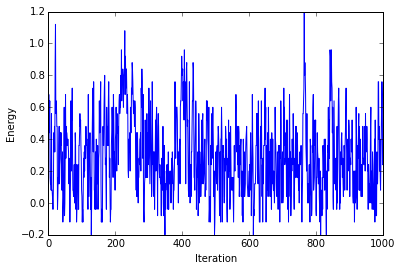

In [2]:
L=10
Nwarmup = 100
Nsteps = 1000
Ndecorr = 3
Temp = 2.27
J = 1.

S = Ising(L, J, Temp)
E = np.zeros(Nsteps)
M = np.zeros(Nsteps)

# Let's start from a "high-energy state"
for i in range(S.N):
    S.spin[i] = 1

for i in range(Nwarmup):
    S.metropolis()

naccept = 0
for i in range(Nsteps):
    for n in range(Ndecorr):
        naccept += S.metropolis()
    E[i] = S.E
    M[i] = abs(S.Mtot)

E /= S.N
M /= S.N


Et = np.sum(E)/Nsteps
E2t = np.sum(E**2)/Nsteps
Mt = np.sum(M)/Nsteps
M2t = np.sum(M**2)/Nsteps

print "T = ", Temp
print "<E>/N = ", Et
print "<E^2>/N = ", E2t
print "<M>/N = ", Mt
print "<M^2>/N = ", M2t
print "C=", (E2t-Et*Et)/Temp/Temp
print "chi=", (M2t-Mt*Mt)/Temp
print "Acceptance ratio = ", float(naccept)/S.N/Nsteps/Ndecorr
        
pyplot.plot(np.arange(0,Nsteps,1),E,ls='-',c='blue');
pyplot.xlabel("Iteration")
pyplot.ylabel("Energy");




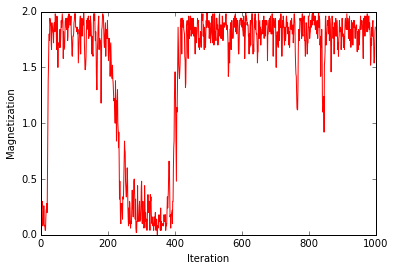

In [3]:
pyplot.plot(np.arange(0,Nsteps,1),M,ls='-',c='red');
pyplot.xlabel("Iteration")
pyplot.ylabel("Magnetization");

#### The system is "stuck" and does not relax

T =  2.27
<E>/N =  -1.44884
<E^2>/N =  2.1664592
<M>/N =  0.73588
<M^2>/N =  0.5871296
C= 0.0130648478333
chi= 0.0200926103965


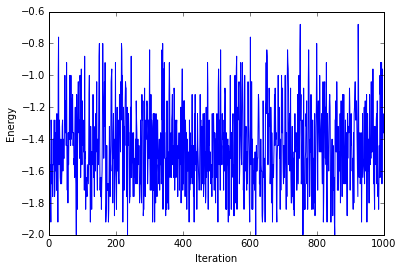

In [4]:
for i in range(S.N):
    S.spin[i] = 1

for i in range(Nsteps):
    for n in range(Ndecorr):
        S.cluster_update()
    E[i] = S.E
    M[i] = abs(S.Mtot)

E /= S.N
M /= S.N


Et = np.sum(E)/Nsteps
E2t = np.sum(E**2)/Nsteps
Mt = np.sum(M)/Nsteps
M2t = np.sum(M**2)/Nsteps

print "T = ", Temp
print "<E>/N = ", Et
print "<E^2>/N = ", E2t
print "<M>/N = ", Mt
print "<M^2>/N = ", M2t
print "C=", (E2t-Et*Et)/Temp/Temp
print "chi=", (M2t-Mt*Mt)/Temp
        
pyplot.plot(np.arange(0,Nsteps,1),E,ls='-',c='blue');
pyplot.xlabel("Iteration")
pyplot.ylabel("Energy");



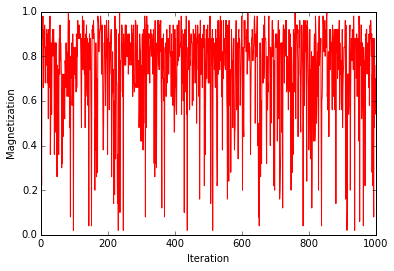

In [5]:
pyplot.plot(np.arange(0,Nsteps,1),M,ls='-',c='red');
pyplot.xlabel("Iteration")
pyplot.ylabel("Magnetization");

#### Cluster updates cover much more phase space than local updates close to a phase transition!

In [11]:
T = np.arange(0.2,8,0.2)

Mt = np.zeros(T.size)
Et = np.zeros(T.size)
M2t = np.zeros(T.size)
E2t = np.zeros(T.size)

S = Ising(L, J, 0.2)

Nsteps = 1000

n = 0
for t in T:
    S.set_temp(t)
    for i in range(Nwarmup):
        S.cluster_update()

    for i in range(Nsteps):
        for j in range(Ndecorr):
            S.cluster_update()
        Et[n] += S.E
        Mt[n] += abs(S.Mtot)
        E2t[n] += S.E**2
        M2t[n] += abs(S.Mtot)**2

    print t, Mt[n]/Nsteps/S.N
    n += 1

Mt /= float(Nsteps*S.N)
Et /= float(Nsteps*S.N)
E2t /= float(Nsteps*S.N*S.N)
M2t /= float(Nsteps*S.N*S.N)
ErrorE = np.sqrt((E2t-Et**2)/Nsteps)
ErrorM = np.sqrt((M2t-Mt**2)/Nsteps)

0.2 1.0
0.4 1.0
0.6 1.0
0.8 0.9999
1.0 0.99938
1.2 0.99676
1.4 0.99194
1.6 0.97966
1.8 0.95756
2.0 0.91298
2.2 0.81256
2.4 0.63724
2.6 0.4246
2.8 0.32816
3.0 0.28956
3.2 0.23926
3.4 0.20464
3.6 0.19802
3.8 0.17948
4.0 0.16692
4.2 0.15652
4.4 0.14636
4.6 0.1434
4.8 0.14484
5.0 0.13904
5.2 0.12914
5.4 0.11862
5.6 0.11964
5.8 0.13368
6.0 0.12028
6.2 0.12396
6.4 0.11142
6.6 0.11454
6.8 0.10738
7.0 0.11146
7.2 0.10584
7.4 0.1126
7.6 0.114
7.8 0.10612


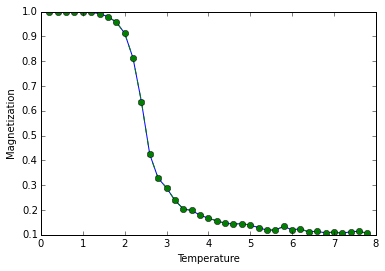

In [12]:
pyplot.plot(T,Mt,ls='-',c='blue')
pyplot.errorbar(T, Mt, yerr=[ErrorM, ErrorM], fmt='--o')
pyplot.ylabel("Magnetization")
pyplot.xlabel("Temperature");

#### Challenge 11.3:

Measure the auto-correlation function and compare local updates and cluster updates
